Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
train.shape, test.shape

((59400, 41), (14358, 40))

In [5]:
train['construction_year']

0        1999
1        2010
2        2009
3        1986
4           0
         ... 
59395    1999
59396    1996
59397       0
59398       0
59399    2002
Name: construction_year, Length: 59400, dtype: int64

In [6]:
import numpy as np

def wrangle(data):
    '''wrangle data on both test and train set'''
    
    # prevent copy warning
    data = data.copy()
    
    # replace almost zeros value in latitude column with a zero
    data['latitude'] = data['latitude'].replace(-2e-08, 0)
    
    # for loop to convert all zeros into a NaN values
    columns_with_zeros = ['latitude', 'longitude', 'population', 'amount_tsh', 'num_private', 'gps_height', 'construction_year']
    for col in columns_with_zeros:
        data[col] = data[col].replace(0, np.NaN)
        
    # convert date_recorded to datetime
    data['date_recorded'] = pd.to_datetime(data['date_recorded'], infer_datetime_format=True)
    
    # Extract component from date recorded, and then drop the original column
    data['year_recorded'] = data['date_recorded'].dt.year
    data = data.drop(columns='date_recorded')
    
    # new features: how many years from construction_year to date_recorded
    data['years_from_construction'] = data['year_recorded'] - data['construction_year']
    
    return data

train = wrangle(train)
test = wrangle(test)

In [7]:
train.shape, test.shape

((59400, 42), (14358, 41))

In [8]:
# target is the status_group column
target = 'status_group'

# drop duplicate columns
duplicate_columns = (['quantity_group', 'quality_group', 
                    'waterpoint_type_group', 'extraction_type_group', 
                    'source_type', 'payment_type'])
# drop both always constant and all random columns
noneed_columns = ['recorded_by', 'id']
# adding both drop list in a new variable
unusuable_columns = duplicate_columns + noneed_columns

# get a dataframe without the target column and unusable_columns
train_features = train.drop([target] + unusuable_columns, axis=1)

# numerical features
numerical_features = train_features.select_dtypes(include='number').columns.to_list()

# categorical_features
categorical_features = train_features.select_dtypes(exclude='number').columns.to_list()

# all of the features to help predict the target
features = numerical_features + categorical_features

# applying features and target to the matrix and vector respectively
X_train = train[features]
y_train = train[target]
X_test = test[features]

In [9]:
X_train.shape, y_train.shape, X_test.shape

((59400, 33), (59400,), (14358, 33))

In [20]:
X_train.isnull().sum()

amount_tsh                 41639
gps_height                 20438
longitude                   1812
latitude                    1812
num_private                58643
region_code                    0
district_code                  0
population                 21381
construction_year          20709
year_recorded                  0
years_from_construction    20709
funder                      3635
installer                   3655
wpt_name                       0
basin                          0
subvillage                   371
region                         0
lga                            0
ward                           0
public_meeting              3334
scheme_management           3877
scheme_name                28166
permit                      3056
extraction_type                0
extraction_type_class          0
management                     0
management_group               0
payment                        0
water_quality                  0
quantity                       0
source    

In [23]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__n_estimators': np.arange(100, 500),
    'randomforestclassifier__min_samples_leaf': np.arange(1, 30),
    'randomforestclassifier__max_depth': [5, None],
    'randomforestclassifier__max_features': np.arange(1, 34),
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    verbose=10,
    random_state=42,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  2.9min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  3.3min remaining:   59.8s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  3.7min remaining:   24.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.8min finished


In [24]:
print('Best Parameters:', search.best_params_)

Best Parameters: {'simpleimputer__strategy': 'mean', 'randomforestclassifier__n_estimators': 445, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_features': 11, 'randomforestclassifier__max_depth': None}


In [25]:
search.best_score_

0.8072222222222223

In [26]:
pipeline = search.best_estimator_
y_pred = pipeline.predict(X_test)
y_pred

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [ ]:
submissions = sample_submission.copy()
submissions['status_group'] = y_pred
submissions.to_csv('nirmal_kaggle_U2_M4_S1-thu.csv', index=False)

# Second try with the same features, by using 10-fold cross-validation

In [28]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__n_estimators': np.arange(100, 500),
    'randomforestclassifier__min_samples_leaf': np.arange(1, 30),
    'randomforestclassifier__max_depth': [5, None],
    'randomforestclassifier__max_features': np.arange(1, 34),
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=10,
    scoring='accuracy',
    verbose=10,
    random_state=42,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 20.6min remaining:   51.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 22.3min finished


In [29]:
print('Best Parameters:', search.best_params_)

Best Parameters: {'simpleimputer__strategy': 'mean', 'randomforestclassifier__n_estimators': 445, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_features': 11, 'randomforestclassifier__max_depth': None}


In [30]:
search.best_score_

0.8153535353535354

In [31]:
pipeline = search.best_estimator_
y_pred = pipeline.predict(X_test)
y_pred

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

# Third try with high iteration and cv of 5

In [32]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__n_estimators': np.arange(100, 500),
    'randomforestclassifier__min_samples_leaf': np.arange(1, 30),
    'randomforestclassifier__max_depth': [5, None],
    'randomforestclassifier__max_features': np.arange(1, 34),
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    verbose=10,
    random_state=42,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 36.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 43

In [33]:
print('Best Parameters:', search.best_params_)

Best Parameters: {'simpleimputer__strategy': 'mean', 'randomforestclassifier__n_estimators': 445, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_features': 11, 'randomforestclassifier__max_depth': None}


In [34]:
search.best_score_

0.8112289562289561

# Confusion matrix for Tanzania

In [35]:
train.shape, test.shape

((59400, 42), (14358, 41))

In [36]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, test_size = len(test), stratify=train[target], random_state=42)
print(train.shape, val.shape, test.shape)

(45042, 42) (14358, 42) (14358, 41)


In [37]:
# drop duplicate columns
duplicate_columns = (['quantity_group', 'quality_group', 
                    'waterpoint_type_group', 'extraction_type_group', 
                    'source_type', 'payment_type'])
# drop both always constant and all random columns
noneed_columns = ['recorded_by', 'id']
# adding both drop list in a new variable
unusuable_columns = duplicate_columns + noneed_columns

# get a dataframe without the target column and unusable_columns
train_features = train.drop([target] + unusuable_columns, axis=1)

# numerical features
numerical_features = train_features.select_dtypes(include='number').columns.to_list()

# categorical_features
categorical_features = train_features.select_dtypes(exclude='number').columns.to_list()

# all of the features to help predict the target
features = numerical_features + categorical_features

# applying features and target to the matrix and vector respectively
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape 

((45042, 33), (45042,), (14358, 33), (14358,), (14358, 33))

In [39]:
from sklearn.metrics import accuracy_score
# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=445, random_state=42, min_samples_leaf=3, max_features= 11, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8152249616938292


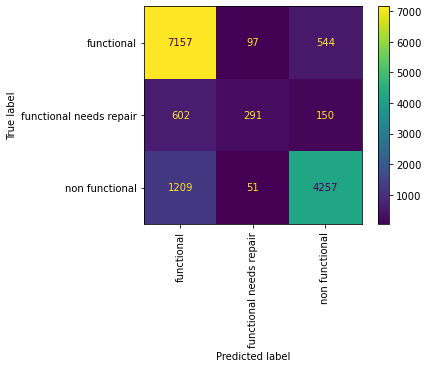

In [40]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

In [41]:
import pandas as pd

# Filenames of your submissions you want to ensemble
files = (['nirmal_kaggle_comp.csv', 'nirmal_kaggle_U2_M3_S1-wed.csv', 'nirmal_kaggle_U2_M4_S1-thu.csv',
         'nirmal_kaggle_U2_S1.csv', 'nirmal_kaggle_U2_S2-wed.csv', 'nirmal_kaggle_U2_S3-wed.csv'])

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

# sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('nirmal_final_kaggle.csv', index=False)

In [42]:
submission

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14353,39307,non functional
14354,18990,functional
14355,28749,functional
14356,33492,functional
